In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
!pip install geopy
from geopy.distance import geodesic


In [46]:
from itertools import combinations

# Choose the nation

#cities = pd.read_csv('cities/vanuatu.csv', header = None, names = ['city', 'lat', 'lon'], index_col = 0)
cities = pd.read_csv('cities/italy.csv', header = None, names = ['city', 'lat', 'lon'], index_col = 0)
#cities = pd.read_csv('cities/russia.csv', header = None, names = ['city', 'lat', 'lon'], index_col = 0)
#cities = pd.read_csv('cities/us.csv', header = None, names = ['city', 'lat', 'lon'], index_col = 0)
#cities = pd.read_csv('cities/china.csv', header = None, names = ['city', 'lat', 'lon'], index_col = 0)

In [47]:
# Function to reorder cities DataFrame with specified start city
def set_start_city(cities_df, start_city):
    # Ensure the start city exists in the index
    if start_city not in cities_df.index:
        raise ValueError(f"City '{start_city}' not found in the dataset.")
    
    # Find the index of the start city
    start_idx = cities_df.index.get_loc(start_city)
    
    # Reorder the DataFrame to have the start city first
    reordered_cities = pd.concat([cities_df.iloc[start_idx:], cities_df.iloc[:start_idx]])
    return reordered_cities

# Choose the starting city among the cities in the nation
start_city = 'Trento'

# Update the cities DataFrame to start with the selected starting city
cities = set_start_city(cities, start_city)

dist_matrix = np.zeros((cities.shape[0], cities.shape[0]))
for (i, c1), (j, c2) in combinations(enumerate(cities.iterrows()), 2):
    distance = geodesic((c1[1]['lat'], c1[1]['lon']), (c2[1]['lat'], c2[1]['lon'])).km
    #approx the distance with two values after the comma and set the distance in the matrix 
    dist_matrix[i, j] = dist_matrix[j, i] = round(distance, 2)
print(dist_matrix)

[[   0.    211.24  290.55 ... 1059.    795.62  408.65]
 [ 211.24    0.    481.19 ...  961.3   639.97  353.77]
 [ 290.55  481.19    0.   ... 1094.47  933.44  487.31]
 ...
 [1059.    961.3  1094.47 ...    0.    414.71  651.06]
 [ 795.62  639.97  933.44 ...  414.71    0.    447.84]
 [ 408.65  353.77  487.31 ...  651.06  447.84    0.  ]]


In [48]:
def plot_tsp_tour(cities, tour):
    # Extract x and y coordinates of the cities
    lat_coords = cities['lat'].values
    lon_coords = cities['lon'].values

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the cities as points
    ax.scatter(lat_coords, lon_coords, color='red', s=50, label='Cities')

    # Highlight the starting city
    start_city = tour[0]
    ax.scatter(lat_coords[start_city], lon_coords[start_city], color='green', s=100, label='Starting City', edgecolor='black', zorder=5)

    # Annotate each city with its index for clarity
    for i, city in enumerate(cities.index):
        ax.annotate(city, (lat_coords[i], lon_coords[i]), textcoords="offset points", xytext=(0, 5), ha='center')

    # Extract the coordinates of the tour in the order of visits
    tour_x = lat_coords[tour]
    tour_y = lon_coords[tour]

    # Plot the tour lines connecting the cities
    ax.plot(tour_x, tour_y, color='blue', label='Tour')

    # Set labels and title
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_title('TSP Tour')

    # Display legend
    ax.legend()

    # Show the plot
    plt.show()

## First solution

Fast but approximated algorithm

Tour: [('Trento', 0), ('Bolzano', 11), ('Vicenza', 5), ('Padua', 29), ('Venice', 3), ('Ferrara', 15), ('Bologna', 10), ('Modena', 25), ("Reggio nell'Emilia", 38), ('Parma', 31), ('Piacenza', 34), ('Milan', 24), ('Monza', 26), ('Bergamo', 9), ('Brescia', 12), ('Verona', 4), ('Ravenna', 36), ('Forlì', 18), ('Rimini', 39), ('Ancona', 6), ('Perugia', 32), ('Terni', 45), ('Rome', 40), ('Latina', 21), ('Giugliano in Campania', 20), ('Naples', 27), ('Salerno', 41), ('Foggia', 17), ('Andria', 7), ('Bari', 8), ('Taranto', 44), ('Messina', 23), ('Reggio di Calabria', 37), ('Catania', 14), ('Syracuse', 43), ('Palermo', 30), ('Cagliari', 13), ('Sassari', 42), ('Leghorn', 22), ('Prato', 35), ('Florence', 16), ('Genoa', 19), ('Novara', 28), ('Turin', 2), ('Trieste', 1), ('Pescara', 33), ('Trento', 0)]
Final cost: 5172.82 km
Number of steps: 46


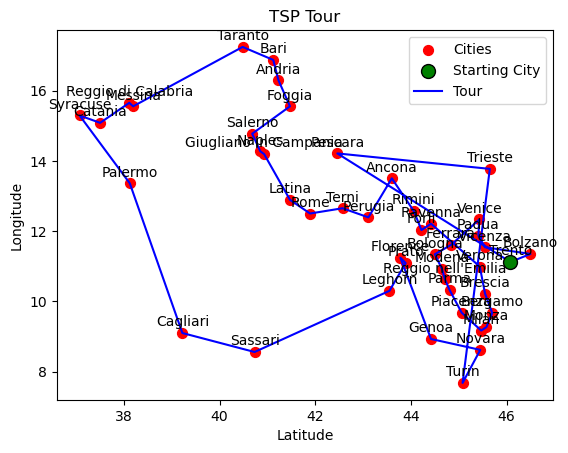

In [49]:
def greedy_tsp(dist_matrix):
    num_cities = dist_matrix.shape[0]
    visited = [False] * num_cities
    tour = []
    total_cost = 0
    
    # start from the first city (the one chosen by the user)
    current_city = 0
    tour.append(current_city)
    visited[current_city] = True

    for _ in range(num_cities - 1):
        # Find the nearest unvisited city
        next_city = np.argmin([dist_matrix[current_city, j] if not visited[j] else np.inf for j in range(num_cities)])
        tour.append(next_city)
        total_cost += dist_matrix[current_city, next_city]
        visited[next_city] = True
        current_city = next_city

    # Return to the starting city
    total_cost += dist_matrix[current_city, tour[0]]
    tour.append(tour[0])

    # Create a list of (city_name, city_index) tuples for the tour
    tour_list = [(cities.index[tour[i]], tour[i]) for i in range(len(tour))]

    return tour_list, total_cost, len(tour) - 1  # len(tour) - 1 is the number of steps

# Run the algorithm and get the result
greedy_tour, greedy_final_cost, greedy_steps = greedy_tsp(dist_matrix)
print(f"Tour: {greedy_tour}")
print(f"Final cost: {round(greedy_final_cost, 3)} km")
print(f"Number of steps: {greedy_steps}")

plot_tsp_tour(cities, [city_index for _, city_index in greedy_tour])

## Second solution

Slower but more accurate algorithm

### Helper functions

In [50]:
# pmx crossover
def pmx(parent1, parent2):
    size = len(parent1)
    child = [-1] * size  # initialize the child route with -1

    # select two point of crossover
    start, end = sorted(random.sample(range(size), 2))

    # copy the segment from the first parent to the child
    child[start:end] = parent1[start:end]

    # mapping the values from the second parent to the first parent
    mapping = {}
    for i in range(start, end):
        mapping[parent1[i]] = parent2[i]

    # fill the remaining positions in the child with values from the second parent
    for i in range(size):
        if child[i] == -1:
            value = parent2[i]
            while value in mapping:
                value = mapping[value]
            child[i] = value

    return np.array(child)


# Inver-over crossover
def inver_over(parent1, parent2):
    size = len(parent1)
    
    # Select two genes randomly from the first parent
    gene1, gene2 = sorted(random.sample(range(size), 2))
    
    # Ensure both selected genes exist in parent2
    try:
        index1 = np.where(parent2 == parent1[gene1])[0][0]
        index2 = np.where(parent2 == parent1[gene2])[0][0]
    except IndexError:
        # If one of the genes is not found, return parent1 or a copy to handle the error gracefully
        return parent1.copy()
    
    # Sort indices to maintain the correct segment order
    index1, index2 = sorted([index1, index2])
    
    # Identify the genes between index1 and index2 in the second parent
    middle_section = parent2[index1 + 1:index2]
    
    # Construct the child
    child = []
    # Add the beginning of the second parent up to index1
    child.extend(parent2[:index1])
    
    # Add the selected genes from parent1
    child.append(parent1[gene1])
    child.append(parent1[gene2])
    
    # Add the middle section in reverse order
    child.extend(reversed(middle_section))
    
    # Add the remaining genes from the second parent, excluding already added genes
    remaining_genes = [gene for gene in parent2 if gene not in child]
    child.extend(remaining_genes)
    
    return np.array(child)

# Crossover
def crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))  # Select two random crossover points
    child = [-1] * size  # Initialize child route with -1
    child[start:end] = parent1[Salernostart:end]  # Copy segment from first parent to child
    
    current_position = end
    for city in parent2:  # Fill the rest of the child with cities from the second parent
        if city not in child:
            child[current_position] = city
            current_position = (current_position + 1) % size
    return np.array(child)

In [51]:
# Function to calculate the total length of a given route
def route_length(route):
    return sum(dist_matrix[route[i], route[i + 1]] for i in range(len(route) - 1)) + dist_matrix[route[-1], route[0]]

# Function to create an initial population of random routes
def create_population(size, n_cities):
    first_city = 0
    return [[first_city] + list(np.random.permutation(range(1, n_cities))) for _ in range(size)]


# Selection function using roulette wheel selection
def selection(population):
    fitness = np.array([1 / route_length(route) for route in population])  # Calculate fitness as inverse of route length
    fitness /= fitness.sum()  # Normalize fitness values
    return population[np.random.choice(range(len(population)), p=fitness)]  # Select a route based on fitness probabilities

# Mutation function to introduce random changes to a route
def mutate(route, mutation_rate):
    if random.random() < mutation_rate:  # Apply mutation based on mutation rate
        idx1, idx2 = random.sample(range(len(route)), 2)  # Select two random indices
        route[idx1], route[idx2] = route[idx2], route[idx1]  # Swap the cities at these indices
    return route

# Function to initialize the population starting from the greedy solution
def initialize_population_with_greedy(greedy_solution, population_size, mutation_rate):
    population = []
    for _ in range(population_size):
        # Initialize the route as a copy of the greedy route
        route = greedy_solution.copy()
        # Apply a slight mutation to create diversity
        route = mutate(route, mutation_rate)
        population.append(route)
    return population

### Genetic Algorithm

In [52]:
# Main function to run the genetic algorithm
def genetic_algorithm(n_cities, mutation_rate, generations, greedy_solution = None, population_size=100, num_elites=10):
    
    if greedy_solution is None:
        # Initialize population with random routes
        population = create_population(population_size, n_cities)  # Initialize population
    else:
        # Initialize population using the greedy solution with slight mutations
        population = [mutate(greedy_solution.copy(), mutation_rate) for _ in range(population_size)]

    best_route = None
    best_length = float('inf')  # Start with infinite best length
    total_generations = generations  # Store the total number of generations processed
   
    for generation in range(generations):
        new_population = []
        # Add elites (preserve top-performing routes)
        elites = sorted(population, key=route_length)[:num_elites]
        new_population.extend(elites)

        for _ in range(population_size - num_elites):  # Ensure new population size remains consistent
            parent1 = selection(population)  # Select first parent
            parent2 = selection(population)  # Select second parent
            child = inver_over(parent1, parent2)  # Create child route using inver-over crossover
            #child = pmx(parent1, parent2)  # Create child route using pmx crossover
            #child = crossover(parent1, parent2) # Create child route using crossover
            child = mutate(child, mutation_rate)  # Apply mutation to the child route
            new_population.append(child)  # Add the new child to the population
        
        population = new_population  # Update population with new generation
        current_best = min(population, key=route_length)  # Find the best route in the population
        current_length = route_length(current_best)  # Calculate its length
        
        # Update the best route and length if current is better
        if current_length < best_length:
            best_route = current_best
            best_length = current_length
            
        # Print progress every 100 generations
        if generation % 100 == 0:
            print(f"Generation {generation}: best length = {round(best_length, 2)} km")
   
    # check if the best route starts from the first city (0)
    if best_route is not None and best_route[0] != 0:
        index_of_first_city = np.where(best_route == 0)[0][0]
        # Rotate the route to start from the first city
        best_route = np.roll(best_route, -index_of_first_city)

    # Add the starting city at the end to complete the cycle
    best_route = np.append(best_route, best_route[0])

    # Create a list of (city_name, city_index) tuples for the tour
    tour_list = [(cities.index[best_route[i]], best_route[i]) for i in range(len(best_route))]
   
    return best_route, best_length, tour_list, total_generations  # Return the best route, length, tour, and total generations

Execute the genetic algorithm starting from random solution but with more generations (2500)

/var/folders/fm/wln7bkw17tqf5hd0q6j09t400000gn/T/ipykernel_96161/814676494.py:37: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  index1 = np.where(parent2 == parent1[gene1])[0][0]


Generation 0: best length = 15372.76 km
Generation 100: best length = 7053.48 km
Generation 200: best length = 5970.12 km
Generation 300: best length = 5242.5 km
Generation 400: best length = 4893.38 km
Generation 500: best length = 4721.99 km
Generation 600: best length = 4568.31 km
Generation 700: best length = 4515.56 km
Generation 800: best length = 4312.01 km
Generation 900: best length = 4293.8 km
Generation 1000: best length = 4293.8 km
Generation 1100: best length = 4276.35 km
Generation 1200: best length = 4276.35 km
Generation 1300: best length = 4244.87 km
Generation 1400: best length = 4222.47 km
Generation 1500: best length = 4214.83 km
Generation 1600: best length = 4194.07 km
Generation 1700: best length = 4181.63 km
Generation 1800: best length = 4181.63 km
Generation 1900: best length = 4181.63 km
Generation 2000: best length = 4181.63 km
Generation 2100: best length = 4181.63 km
Generation 2200: best length = 4181.63 km
Generation 2300: best length = 4181.63 km
Genera

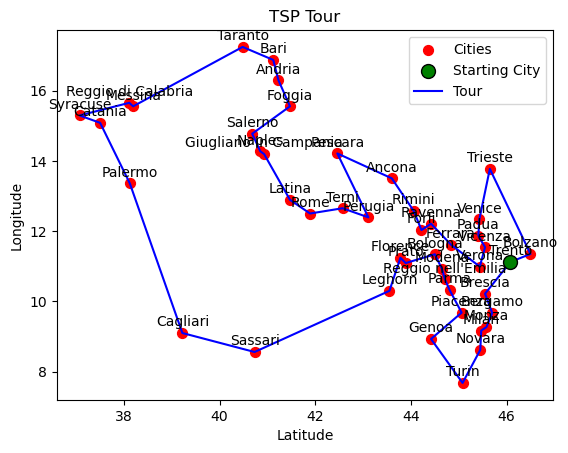

In [53]:
# Execute the genetic algorithm starting from random solution
mutation_rate = 0.3
generations=2500
best_route, best_length, tour_list, total_generations = genetic_algorithm(n_cities=cities.shape[0], mutation_rate=mutation_rate, generations=generations)

# Print the results
print(f"Number of generations: ", generations)
print(f"Tour: {tour_list}")
print(f"Final cost: {round(best_length, 3)} km")
print(f"Number of steps (generations processed): {total_generations}")

# Visualize the best tour found
plot_tsp_tour(cities, best_route)

Execute the genetic algorithm starting from greedy solution but with less generations (1500)

/var/folders/fm/wln7bkw17tqf5hd0q6j09t400000gn/T/ipykernel_96161/814676494.py:37: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  index1 = np.where(parent2 == parent1[gene1])[0][0]
/var/folders/fm/wln7bkw17tqf5hd0q6j09t400000gn/T/ipykernel_96161/814676494.py:38: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  index2 = np.where(parent2 == parent1[gene2])[0][0]


Generation 0: best length = 5100.47 km
Generation 100: best length = 4754.99 km
Generation 200: best length = 4620.78 km
Generation 300: best length = 4552.54 km
Generation 400: best length = 4470.3 km
Generation 500: best length = 4423.12 km
Generation 600: best length = 4417.28 km
Generation 700: best length = 4399.7 km
Generation 800: best length = 4277.11 km
Generation 900: best length = 4273.79 km
Generation 1000: best length = 4272.97 km
Generation 1100: best length = 4185.05 km
Generation 1200: best length = 4185.05 km
Generation 1300: best length = 4175.24 km
Generation 1400: best length = 4175.24 km
Number of generations:  1500
Tour: [('Trento', 0), ('Verona', 4), ('Brescia', 12), ('Bergamo', 9), ('Monza', 26), ('Milan', 24), ('Novara', 28), ('Turin', 2), ('Genoa', 19), ('Piacenza', 34), ('Parma', 31), ("Reggio nell'Emilia", 38), ('Modena', 25), ('Bologna', 10), ('Prato', 35), ('Florence', 16), ('Leghorn', 22), ('Sassari', 42), ('Cagliari', 13), ('Palermo', 30), ('Catania', 14

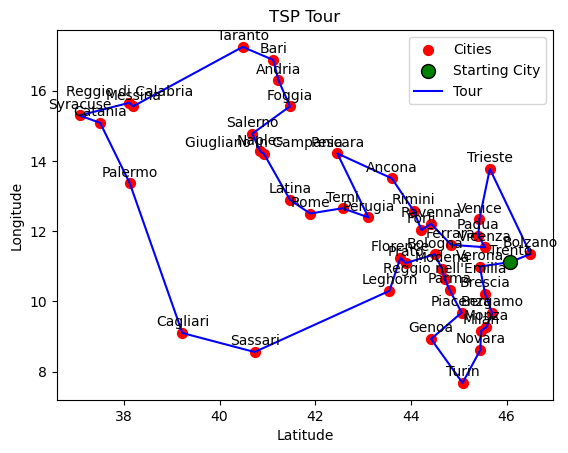

In [54]:
# Execute the genetic algorithm starting from greedy solution
greedy_solution = [city_index for _, city_index in greedy_tour]
mutation_rate = 0.3
generations = 1500
best_route, best_length, tour_list, total_generations = genetic_algorithm(n_cities=cities.shape[0], mutation_rate=mutation_rate, generations=generations, greedy_solution=greedy_solution)

# Print the results
print(f"Number of generations: ", generations)
print(f"Tour: {tour_list}")
print(f"Final cost: {round(best_length, 3)} km")
print(f"Number of steps (generations processed): {total_generations}")

# Visualize the best tour found
plot_tsp_tour(cities, best_route)